# Chapter 3: LogReg nb IMBD
Note this notebook is too long. So long that at the final section you are almost always confirmed to have kernel dead. At least that's what one experienced. Try to rerun it again and see if it works or not. 

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.text.all import *

In [4]:
import sklearn.feature_extraction.text as sklearn_text
import _pickle as cPickle
import numpy as np

In [5]:
path = untar_data(URLs.IMDB_SAMPLE)
path

Path('/home/fastai2/.fastai/data/imdb_sample')

In [6]:
df = pd.read_csv(path/"texts.csv")
df.head()

,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False
2,negative,"Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt li...",False
3,positive,"Name just says it all. I watched this movie with my dad when it came out and having served in Korea he had great admiration for the man. The disappointing thing about this film is that it only concentrate on a short period of the man's life - interestingly enough the man's entire life would have made such an epic bio-pic that it is staggering to imagine the cost for production.<br /><br />Some posters elude to the flawed characteristics about the man, which are cheap shots. The theme of the movie ""Duty, Honor, Country"" are not just mere words blathered from the lips of a high-brassed offic...",False
4,negative,"This movie succeeds at being one of the most unique movies you've seen. However this comes from the fact that you can't make heads or tails of this mess. It almost seems as a series of challenges set up to determine whether or not you are willing to walk out of the movie and give up the money you just paid. If you don't want to feel slighted you'll sit through this horrible film and develop a real sense of pity for the actors involved, they've all seen better days, but then you realize they actually got paid quite a bit of money to do this and you'll lose pity for them just like you've alr...",False


In [7]:
path.ls()

(#1) [Path('/home/fastai2/.fastai/data/imdb_sample/texts.csv')]

In [8]:
imdb_clas = DataBlock(
    blocks=(TextBlock.from_df("text", seq_len=72), CategoryBlock),
    get_x=ColReader("text"), get_y=ColReader("label"), splitter=ColSplitter()
)

dls = imdb_clas.dataloaders(df, bs=64)
dls.show_batch()

/anaconda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,text,category
0,"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n\n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj victor xxmaj vargas became i was always aware that something did n't quite feel right . xxmaj victor xxmaj vargas suffers from a certain xxunk on the director 's part . xxmaj apparently , the director thought that the ethnic backdrop of a xxmaj latino family on the lower east side , and an xxunk storyline would make the film critic proof . xxmaj he was right , but it did n't fool me . xxmaj raising xxmaj victor xxmaj vargas is",negative
1,"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with the xxunk possible scenarios to get the two protagonists together in the end . xxmaj in fact , all its charm is xxunk , contained within the characters and the setting and the plot … which is highly believable to xxunk . xxmaj it 's easy to think that such a love story , as beautiful as any other ever told , * could * happen to you … a feeling you do n't often get from other romantic comedies",positive
2,"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n\n xxmaj it 's usually satisfying to watch a film director change his style / subject , but xxmaj soderbergh 's most recent stinker , xxmaj the xxmaj girlfriend xxmaj xxunk ) , was also missing a story , so narrative ( and editing ? ) seem to suddenly be xxmaj soderbergh 's main challenge . xxmaj strange , after xxunk years in the business . xxmaj he was probably never much good at narrative , just xxunk it well inside "" edgy "" projects . \n\n xxmaj none of this excuses him this present , almost diabolical",negative
3,"xxbos xxmaj this film sat on my xxmaj xxunk for weeks before i watched it . i xxunk a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj xxunk . \n\n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" la xxmaj xxunk , "" based on a play by xxmaj arthur xxmaj xxunk , who is given an "" inspired by "" credit . xxmaj it starts from one person , a prostitute , standing on a street corner in xxmaj brooklyn . xxmaj she is picked up by a home contractor , who has sex with her on the hood of a car , but ca n't come . xxmaj he refuses to pay her . xxmaj when he 's off xxunk , she",positive
4,"xxbos i really wanted to love this show . i truly , honestly did . \n\n xxmaj for the first time , gay viewers get their own version of the "" the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance of love with 15 suitors ( or "" mates "" as they are referred to in the show ) . xxmaj the only problem is half of them are straight and xxmaj james does n't know this . xxmaj if xxmaj james picks a gay one , they get a trip to xxmaj new xxmaj zealand , and xxmaj if he picks a straight one , straight guy gets $ 25 , xxrep 3 0 . xxmaj how can this not be fun",negative
5,"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk gami

In [9]:
# Or optionally: 
# dls = TextDataLoaders.from_df(df, path=path, text_col="text", label_col="label",
#                 valid_col="is_valid")
# dls.show_batch()

In [10]:
dir(dls)

['_DataLoader__idxs',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_tfms',
 '_after_item',
 '_call',
 '_component_attr_filter',
 '_component_attr_filter',
 '_component_attr_filter',
 '_dbunch_type',
 '_dbunch_type',
 '_decode_batch',
 '_default',
 '_default',
 '_default',
 '_device',
 '_dir',
 '_dir',
 '_dir',
 '_dl_type',
 '_dl_type',
 '_do_call',
 '_do_one',
 '_docs',
 '_docs',
 '_get',
 '_is_showable',
 '_methods',
 '_n_inp',
 '_new',
 '_new',
 '_noop_methods',
 '_one_pass',
 '_pre_show_batch',
 '_repr_pretty_',
 '_retain_dl',
 '_set',
 '_tokenize1',
 '_types',
 'add',
 'add_na',
 'add_tfms',
 'after_batch',
 

In [11]:
print(f"There are {len(dls.train_ds)} and {len(dls.valid_ds)} reviews in the " \
"training and validations sets, respectively.")

There are 800 and 200 reviews in the training and validations sets, respectively.


In [12]:
np.array(dls.vocab[0])

array(['xxunk', 'xxpad', 'xxbos', ..., 'xxfake', 'xxfake', 'xxfake'],
      dtype='<U17')

In [13]:
rare_words = ['acrid','a_random_made_up_nonexistant_word',
        'acrimonious','allosteric','anodyne','antikythera']
[(word in dls.vocab[0]) for word in rare_words]

[False, False, False, False, False, False]

In [14]:
# Default value
dls.vocab[0][0]

'xxunk'

In [15]:
torch.count_nonzero((dls.train.one_batch()[0][0] == 0).cpu()).item()

84

In [16]:
unk_tot = 0
for data, items in dls.train:
    unk_tot += torch.count_nonzero((data[0].squeeze() == 0).cpu()).item()

unk_tot

265

In [17]:
dls.vocab[0][:25]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 'the',
 ',',
 '.',
 'and',
 'a',
 'of',
 'to',
 'is',
 'it',
 'in',
 'i',
 'that',
 'this',
 '"',
 "'s",
 '-']

In [18]:
len(dls.vocab.itemgot()[0])

7080

In [19]:
TokenCounter = lambda review_index: Counter((dls.items.text)[review_index])
TokenCounter(0).items()

dict_items([('xxbos', 1), ('xxmaj', 14), ('un', 1), ('-', 3), ('bleeping', 1), ('believable', 1), ('!', 3), ('meg', 1), ('ryan', 1), ('does', 1), ("n't", 1), ('even', 1), ('look', 1), ('her', 2), ('usual', 1), ('pert', 1), ('lovable', 1), ('self', 1), ('in', 1), ('this', 3), (',', 1), ('which', 1), ('normally', 1), ('makes', 1), ('me', 1), ('forgive', 1), ('shallow', 1), ('ticky', 1), ('acting', 1), ('schtick', 1), ('.', 3), ('hard', 1), ('to', 1), ('believe', 1), ('she', 1), ('was', 2), ('the', 2), ('producer', 1), ('on', 2), ('dog', 1), ('plus', 1), ('kevin', 1), ('kline', 1), (':', 1), ('what', 1), ('kind', 1), ('of', 2), ('suicide', 1), ('trip', 1), ('has', 1), ('his', 1), ('career', 1), ('been', 1), ('?', 2), ('whoosh', 1), ('…', 1), ('banzai', 1), ('xxrep', 3), ('3', 3), ('finally', 1), ('directed', 1), ('by', 1), ('guy', 1), ('who', 1), ('did', 1), ('big', 1), ('chill', 1), ('must', 1), ('be', 1), ('a', 1), ('replay', 1), ('jonestown', 1), ('hollywood', 1), ('style', 1), ('w', 1

In [20]:
TokenCounter = lambda review_index: Counter(dls.train_ds[review_index][0].numpy())
TokenCounter(0).items()

dict_items([(2, 1), (8, 14), (4499, 1), (24, 3), (0, 7), (951, 1), (54, 3), (4500, 1), (1769, 1), (95, 1), (37, 1), (78, 1), (198, 1), (62, 2), (852, 1), (2184, 1), (507, 1), (18, 1), (21, 3), (10, 1), (86, 1), (2035, 1), (192, 1), (90, 1), (3814, 1), (1895, 1), (124, 1), (11, 3), (251, 1), (15, 1), (277, 1), (73, 1), (25, 2), (9, 2), (1651, 1), (35, 2), (1138, 1), (1096, 1), (1353, 1), (2921, 1), (92, 1), (64, 1), (240, 1), (14, 2), (1576, 1), (1484, 1), (66, 1), (41, 1), (790, 1), (107, 1), (69, 2), (87, 1), (5, 3), (161, 3), (567, 1), (642, 1), (48, 1), (265, 1), (53, 1), (89, 1), (218, 1), (234, 1), (43, 1), (13, 1), (4501, 1), (4502, 1), (392, 1), (427, 1), (2627, 1), (1354, 1), (1288, 1)])

In [21]:
TokenCounter(0).keys()

dict_keys([2, 8, 4499, 24, 0, 951, 54, 4500, 1769, 95, 37, 78, 198, 62, 852, 2184, 507, 18, 21, 10, 86, 2035, 192, 90, 3814, 1895, 124, 11, 251, 15, 277, 73, 25, 9, 1651, 35, 1138, 1096, 1353, 2921, 92, 64, 240, 14, 1576, 1484, 66, 41, 790, 107, 69, 87, 5, 161, 567, 642, 48, 265, 53, 89, 218, 234, 43, 13, 4501, 4502, 392, 427, 2627, 1354, 1288])

In [22]:
TokenCounter(0).values()

dict_values([1, 14, 1, 3, 7, 1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Make Embedding Vectors
Instead of 6016 tokens that have in fastai1, we have 7080 tokens in fastai v2. 

In [23]:
n_terms = len(dls.vocab.itemgot()[0])
n_docs = len(dls.items.text)
make_token_counter = lambda review_index: Counter(dls.train_ds[review_index][0].numpy())

def count_vectorizer(review_index, n_terms=n_terms, 
        make_token_counter=make_token_counter):
    """
    Input: review index, n_terms, tokenizer function. 
    output: embedding vector for the review. 
    """
    embedding_vector = np.zeros(n_terms)
    keys = list(make_token_counter(review_index).keys())
    values = list(make_token_counter(review_index).values())
    embedding_vector[keys] = values
    return embedding_vector


embedding_vector = count_vectorizer(0)  # first review

In [24]:
print(f"The review is embedded in a {len(embedding_vector)} dimensional vector.")
embedding_vector

The review is embedded in a 7080 dimensional vector.


array([7., 0., 1., ..., 0., 0., 0.])

## Create a document-term matrix for IMDB

In [25]:
def make_full_doc_term_matrix(count_vectorizer, n_terms=n_terms, n_docs=n_docs):
    for doc_index in range(n_docs):
        embedding_vector = count_vectorizer(doc_index, n_terms)

        # Append emb vec to doc-term matrix. 
        if doc_index == 0: A = embedding_vector
        else: A = np.vstack((A, embedding_vector))

    return A

try: A = load_pickle(Path("output/A.pkl"))
except Exception: 
    A = make_full_doc_term_matrix(count_vectorizer)
    save_pickle(Path("output/A.pkl"), A)

### Explore sparsity of document-term matrix
This is defined as the fraction of zero-valued elements. 

In [26]:
NNZ = np.count_nonzero(A)
sparsity = (A.size - NNZ) / A.size
print(f"Only {NNZ} of the size {A.size} elements in the document-term matrix "\
    "are nonzero.")
print(f"The sparsity of the document-term matrix is {sparsity}.")

Only 114091 of the size 5664000 elements in the document-term matrix are nonzero.
The sparsity of the document-term matrix is 0.9798568149717514.


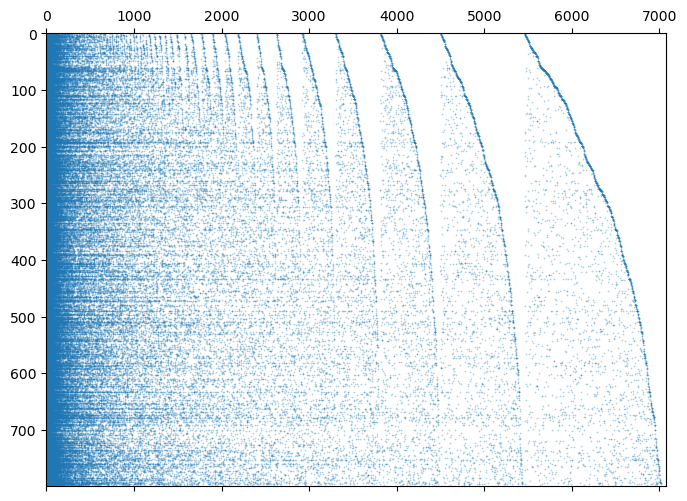

In [27]:
fig = plt.figure(dpi=100)
plt.spy(A, markersize=0.10, aspect="auto")
fig.set_size_inches(8, 6)
fig.savefig("output/doc_term_matrix.png", dpi=800)

### Observation of image code cell above. 
1) Document-term matrix is *sparse*.  
2) Density of matrix increases toward *left* edge. This makes sense because tokens are ordered by usage frequency, with frequency increasing toward the left.  
3) There is a perplexing pattern of curved vertical *density ripples*. 

## Sparse matrix storage format (representation)

1) Coordinate-wise storage.  
Store using 3 arrays: the row, column and its value. We represent it coordinate-wise: we store the value say 75 at row 6 column 4. The space that is used is $\text{number of entries} \times 3$. The same value can show up multiple times, but the row and column varies. Accessing matrix elements looking by row or column is easy, and it not needed be ordered.  

2) Compressed Sparse Row (CSR).  
Store using 3 arrays: Value, Column and RowPointer (contains row-index range). Row Pointer array will be shorter than other arrays. It doesn't directly correspond to others. If the second value is 3: it means that at index 3 it will jump to the next row. Third value stores the index of item which it starts jumping to the next row. We continue this until the final row. The first value is always 0 signifying the beginning. Benefit is it stores even less than previous. If you access data by row a lot, this is easy way to do it. **Column access is difficult**. Entries from row requires consecutively located next to each other. 

3) Compressed Sparse Column (CSC).  
Opposite of CSR. 

Other methods for storing matrices also available. Choose based on knowledge of underlying data structure. 

Advantage of CSR over coordinate-wise: number of operations for matrix-vector multiplication are the same. But number of memory accessed *is reduced (by 2 exactly) in CSR method*. 

### Translate regular matrix A into CSR format. 

In [28]:
def get_doc_term_matrix(train_ds, n_terms):
    """
    inputs: train_ds, n_terms. 
    output: CSR format as scipy.sparse.csr.csr_matrix object. 
    """
    values, column_indices, row_pointer = [], [], []
    row_pointer.append(0)

    for _, (doc, label) in enumerate(train_ds):
        feature_counter = Counter(doc.data.numpy())
        column_indices.extend(feature_counter.keys())
        values.extend(feature_counter.values())
         # Tack on N (number of nonzero elements in the matrix) to the end of the row_pointer array
        row_pointer.append(len(values))

    return scipy.sparse.csr_matrix((values, column_indices, row_pointer),
                                    shape=(len(row_pointer) - 1, n_terms),
                                    dtype=int)
        

In [29]:
%%time
train_doc_term = get_doc_term_matrix(dls.train_ds, n_terms)

CPU times: user 848 ms, sys: 10.5 ms, total: 858 ms
Wall time: 857 ms


In [30]:
type(train_doc_term), train_doc_term.shape

(scipy.sparse.csr.csr_matrix, (800, 7080))

For validation data

In [31]:
%time valid_doc_term = get_doc_term_matrix(dls.valid_ds, n_terms)

CPU times: user 214 ms, sys: 4.23 ms, total: 218 ms
Wall time: 216 ms


In [32]:
type(valid_doc_term), valid_doc_term.shape

(scipy.sparse.csr.csr_matrix, (200, 7080))

In [33]:
values, column_indices, row_pointer = [], [], []
row_pointer.append(0)

for _, (doc, label) in enumerate(dls.train_ds):
    feature_counter = Counter(doc.data.numpy())
    column_indices.extend(feature_counter.keys())
    values.extend(feature_counter.values())
        # Tack on N (number of nonzero elements in the matrix) to the end of the row_pointer array
    row_pointer.append(len(values))

In [34]:
values = np.array(values)
column_indices = np.array(column_indices)
row_pointer = np.array(row_pointer)

In [35]:
scipy.sparse.csr_matrix((values, column_indices, row_pointer),
                        shape=(len(row_pointer) - 1, n_terms),
                        dtype=int)

<800x7080 sparse matrix of type '<class 'numpy.int64'>'
	with 114091 stored elements in Compressed Sparse Row format>

### Reconstruct a regular matrix from CSR sparse representation. 
Given CSR format (values, column_indices, row_pointer) of $m \times n$ matrix $A$, how can we recover $A$? We create the matrix first with all zeros, and overwriting entries with non-zero entries in $A$. 

In [36]:
def CSR_to_full(values, column_indices, row_ptr, m, n):
    A = np.zeros(m, n)
    for row in range(n):
        if row_ptr is not null:
            A[row, column_indices[row_ptr[row] : row_ptr[row + 1]]] = values[row_ptr[row] : row_ptr[row + 1]]

    return A

In [37]:
valid_doc_term.todense()[:10, :10]

matrix([[ 20,   0,   1,   0,   0,   0,   0,   1,  32,  10],
        [  6,   0,   1,   0,   0,   0,   0,   1,   7,   7],
        [  1,   0,   1,   0,   0,   0,   0,   0,  19,  12],
        [ 55,   0,   1,   0,   0,   0,   0,   0,  43,  44],
        [ 91,   0,   1,   0,   0,   0,   0,  14, 113,  42],
        [ 12,   0,   1,   0,   0,   0,   0,   0,  22,   6],
        [  4,   0,   1,   0,   0,   0,   0,   0,  20,   8],
        [ 25,   0,   1,   0,   0,   2,   0,   7,  34,  25],
        [  5,   0,   1,   0,   0,   0,   0,   1,  16,   9],
        [ 12,   0,   1,   0,   0,   1,   0,   2,  14,   5]])

Consider second review in the validation set. 

In [38]:
review = dls.items.text[1]
review

(#462) ['xxbos','xxmaj','this','is','a','extremely','well','-','made','film'...]

In [39]:
# Count how many "it" inside this review. 
Counter(review)["it"]

7

In [40]:
valid_doc_term[1].sum(), len(set(review))

(145, 210)

In [41]:
review = dls.train_ds[1][0]

Convert back to text. 

In [42]:
word_list = [dls.vocab.itemgot()[0][int(a)] for a in review]
print(word_list)

['xxbos', 'xxmaj', 'this', 'is', 'a', 'extremely', 'well', '-', 'made', 'film', '.', 'xxmaj', 'the', 'acting', ',', 'script', 'and', 'camera', '-', 'work', 'are', 'all', 'first', '-', 'rate', '.', 'xxmaj', 'the', 'music', 'is', 'good', ',', 'too', ',', 'though', 'it', 'is', 'mostly', 'early', 'in', 'the', 'film', ',', 'when', 'things', 'are', 'still', 'relatively', 'xxunk', '.', 'xxmaj', 'there', 'are', 'no', 'really', 'xxunk', 'in', 'the', 'cast', ',', 'though', 'several', 'faces', 'will', 'be', 'familiar', '.', 'xxmaj', 'the', 'entire', 'cast', 'does', 'an', 'excellent', 'job', 'with', 'the', 'script', '.', '\n\n', 'xxmaj', 'but', 'it', 'is', 'hard', 'to', 'watch', ',', 'because', 'there', 'is', 'no', 'good', 'end', 'to', 'a', 'situation', 'like', 'the', 'one', 'presented', '.', 'xxmaj', 'it', 'is', 'now', 'xxunk', 'to', 'blame', 'the', 'xxmaj', 'british', 'for', 'setting', 'xxmaj', 'hindus', 'and', 'xxmaj', 'muslims', 'against', 'each', 'other', ',', 'and', 'then', 'xxunk', 'xxunk',

In [43]:
reconstructed_text = " ".join(word_list)
print(reconstructed_text)

xxbos xxmaj this is a extremely well - made film . xxmaj the acting , script and camera - work are all first - rate . xxmaj the music is good , too , though it is mostly early in the film , when things are still relatively xxunk . xxmaj there are no really xxunk in the cast , though several faces will be familiar . xxmaj the entire cast does an excellent job with the script . 

 xxmaj but it is hard to watch , because there is no good end to a situation like the one presented . xxmaj it is now xxunk to blame the xxmaj british for setting xxmaj hindus and xxmaj muslims against each other , and then xxunk xxunk them into two countries . xxmaj there is some merit in this view , but it 's also true that no one forced xxmaj hindus and xxmaj muslims in the region to xxunk each other as they did around the time of partition . xxmaj it seems more likely that the xxmaj british simply saw the xxunk between the xxunk and were clever enough to exploit them to their own ends . 

 xxmaj the result i

# Video 5 material: 
## Naive Bayes Classifier. 

In [44]:
dls.vocab.itemgot()[1]

['negative', 'positive']

They are arranged according to their index, so `negative` is in index 0 hence the integer representation is 0, while `positive` is 1. 

In [45]:
m = np.array(dls.vocab.itemgot()[1])
positive = np.where(m == "positive")[0].item()
negative = np.where(m == "negative")[0].item()

In [46]:
dls.train_ds.c

2

In [47]:
g = np.array(dls.train_ds.items.label)
lookupTable, train_y = np.unique(g, return_inverse=True)
assert (lookupTable == np.array(dls.train.vocab.itemgot()[1])).all()

In [48]:
g = np.array(dls.valid_ds.items.label)
lookupTable, valid_y = np.unique(g, return_inverse=True)
assert (lookupTable == np.array(dls.valid.vocab.itemgot()[1])).all()

In [49]:
x = train_doc_term
y = train_y
valid_y = valid_y
v = np.array(dls.vocab[0])

In [50]:
x.shape

(800, 7080)

Unsure about why `x.shape` in original is (800, 260402). 

Next we list total occurrences count of tokens in positive and negative review. 

In [51]:
C1 = np.squeeze(np.asarray(x[y==positive].sum(0)))
C0 = np.squeeze(np.asarray(x[y==negative].sum(0)))

In [52]:
print(C1[:10])
print(C0[:10])

[5698    0  383    0    0   64    0  627 9675 5249]
[ 6275     0   417     0     0    93     3   852 10288  6143]


How often does "love" appear in negative vs positive review? 

Since we are going to acquire the original `stoi` we are going to write a function for it. 

In [53]:
"""
:vocab: (np.array) vocabulary.
:word: (str) word to search. 
"""
def stoi(vocab, word): return np.where(np.array(vocab) == word)[0].item()

In [54]:
def itos(vocab, word): return vocab[word]

In [55]:
ind = stoi(v, "love")
pos_counts = C1[ind]
neg_counts = C0[ind]
print(f"The word 'love' appears {pos_counts} and {neg_counts} times in "\
    "positive and negative documents, respectively.")

The word 'love' appears 132 and 75 times in positive and negative documents, respectively.


In [56]:
# How often does the word "hate" appear in neg vs pos reviews? 
ind = stoi(v, "hate")
pos_counts = C1[ind]
neg_counts = C0[ind]
print(f"The word 'hate' appears {pos_counts} and {neg_counts} times in "\
    "positive and negative documents, respectively.")

The word 'hate' appears 5 and 13 times in positive and negative documents, respectively.


Let's took an example of a positive review containing the word "hate". And vice versa. This can confirm that this is really a positive and negative review and not labelling error. 

In [57]:
np.set_printoptions(threshold=50)

In [58]:
# We also develop a function to replace `movie_reviews.train.x[c].text` for below. 
def get_train_x_c(dls, c, train=True): 
    if train==True: return " ".join(dls.train_ds.items.text[c])
    else: return " ".join(dls.valid_ds.items.text[c])

In [59]:
index = stoi(v, "hated")
a = np.argwhere((x[:, index] > 0))[:, 0]
print(a)
b = np.argwhere(y==positive)[:, 0]
print(b)
# Choose one text
c = list(set(a).intersection(set(b)))[0]
review = get_train_x_c(dls, c)
review

[ 15  49 304 351 393 612 695 773]
[  1   3  10 ... 789 790 797]


'xxbos xxmaj there are numerous films relating to xxup ww2 , but xxmaj mother xxmaj night is quite distinctive among them : xxmaj in this film , we are introduced to xxmaj howard xxmaj campbell ( nolte ) , an xxmaj american living in xxmaj berlin and married to a xxmaj german , xxmaj helga xxmaj noth ( lee ) , who decides to accept the role of a spy : xxmaj more specifically , a xxup cia agent xxmaj major xxmaj wirtanen ( goodman ) recruits xxmaj campbell who becomes a xxmaj nazi propagandist in order to enter the highest echelons of the xxmaj hitler regime . xxmaj however , the deal is that the xxup us xxmaj government will never acknowledge xxmaj campbell \'s role in the war for national security reasons , and so xxmaj campbell becomes a hated figure across the xxup us . xxmaj after the war , he tries to conceal his identity , but the past comes back and haunts him . xxmaj his only " friend " is xxmaj wirtanen , but even he can not do much for the avalanche of events that fall upon p

In [60]:
# Example of a negative review with the word love. 
index = stoi(v, "loved")
a = np.argwhere((x[:, index] > 0))[:, 0]
print(a)
b = np.argwhere(y==negative)[:, 0]
print(b)
c = list(set(a).intersection(set(b)))[0]
review = get_train_x_c(dls, c)
review

[  1  15  29  69  75  79 174 185 200 205 262 296 303 333 350 351 398 407
 440 489 496 528 538 600 602 605 627 642 657 660 700 712 729 735 755 767
 785]
[  0   2   4 ... 796 798 799]


'xxbos xxmaj oh if only i could give this rubbish less than one star ! xxmaj there were two mildly amusing parts in the whole film and that is it ! one was where a line or two from the song xxmaj do n\'t xxmaj worry , xxmaj be xxmaj happy was sung by the slugs and the other was where xxmaj roddy fell of the toilet roll and landed with his feet and legs apart so that everything else he landed on on the way down hit him in the groin . xxmaj that is it there was nothing more amusing than that , at least not for me anyway ! xxmaj doctornappy2 is not right in saying \' fans of the completely terrible " shrek " might enjoy , but " wallace & xxmaj gromit " fans will probably turn away in disgust . \' xxmaj as i loved xxmaj shrek 1 2 and 3 and i also love xxmaj wallace and xxmaj gromit . xxmaj you see what it boils down to is that if an animation is done extremely well then it is definitely worth watching , this however was about as far from done well as you can possibly get ! xxmaj the contin

### Building Naïve Bayes Classifier. 
Let's first compute the class likelihood AND the log-count ratios. 

In [61]:
# class likelihood
L1 = (C1 + 1) / ((y == positive).sum() + 1)
L0 = (C0 + 1) / ((y == negative).sum() + 1)

# Log-count ratio
R = np.log(L1 / L0)
print(R)

[-0.01160323  0.08483888  0.         ...  0.08483888  0.08483888
  0.08483888]


Find the vocabulary words most likely to be associated with positive and negative reviews. 

In [62]:
# Get indices of the tokens with highest and lowest log-count ratios
n_tokens = 10
highest_R = np.argpartition(R, -n_tokens)[-n_tokens:]
lowest_R = np.argpartition(R, n_tokens)[:n_tokens]

print(f"Highest {n_tokens} log-count ratios: {R[list(highest_R)]}\n")
print(f"Lowest {n_tokens} log-count ratios: {R[list(lowest_R)]}")

Highest 10 log-count ratios: [2.56974553 2.64978824 2.64978824 2.72389621 2.64978824 2.79288908
 2.72389621 2.8574276  2.97521064 3.02927786]

Lowest 10 log-count ratios: [-2.80553288 -2.55421845 -2.68774984 -2.8596001  -2.63645655 -2.62321132
 -2.55421845 -3.09321495 -3.13403694 -2.74837446]


In [63]:
# Most positive words
highest_R

array([2147, 1766, 1965,  935, 2033, 1193, 1758, 1646, 1483, 1414])

In [64]:
[itos(v, k) for k in highest_R]

['paxton',
 'davies',
 'jabba',
 'jimmy',
 'gilliam',
 'noir',
 'felix',
 'astaire',
 'fanfan',
 'biko']

There are only 2 movie reviews mention "biko".

In [65]:
token = "biko"
train_doc_term[:, stoi(v, token)]

<800x1 sparse matrix of type '<class 'numpy.int64'>'
	with 2 stored elements in Compressed Sparse Row format>

Which movie review has most occurrences of "biko"?

In [66]:
index = np.argmax(train_doc_term[:, stoi(v, token)])
n_times = train_doc_term[index, stoi(v, token)]
print(f"Review # {index} has {n_times} occurrences of '{token}'\n")
print(get_train_x_c(dls, index))

Review # 515 has 14 occurrences of 'biko'

xxbos " the xxmaj true xxmaj story xxmaj of xxmaj the xxmaj friendship xxmaj that xxmaj shook xxmaj south xxmaj africa xxmaj and xxmaj awakened xxmaj the xxmaj world . " 

 xxmaj richard xxmaj attenborough , who directed " a xxmaj bridge xxmaj too xxmaj far " and " gandhi " , wanted to bring the story of xxmaj steve xxmaj biko to life , and the journey and trouble that journalist xxmaj donald xxmaj woods went through in order to get his story told . xxmaj the films uses xxmaj wood 's two books for it 's information and basis - " biko " and " asking for xxmaj trouble " . 

 xxmaj the film takes place in the late 1970 's , in xxmaj south xxmaj africa . xxmaj south xxmaj africa is in the grip of the terrible apartheid , which keeps the blacks separated from the whites and classifies the whites as the superior race . xxmaj the blacks are forced to live in shantytowns on the outskirts of the cities and towns , and they come under frequent harassmen

Most negative words:

In [67]:
lowest_R

array([1452, 1894, 1635,  559,  287, 1344, 1893, 1137,  988, 1138])

In [68]:
[itos(v, k) for k in lowest_R]

['naschy',
 'soderbergh',
 'crater',
 'crap',
 'worst',
 'disappointment',
 'fuqua',
 'vargas',
 'porn',
 'dog']

In [69]:
# There's only one movie review mentions soderbergh
token = "soderbergh"
train_doc_term[:, stoi(v, token)]

<800x1 sparse matrix of type '<class 'numpy.int64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [70]:
index = np.argmax(train_doc_term[:, stoi(v, token)])
n_times = train_doc_term[index, stoi(v, token)]
print(f"Review # {index} has {n_times} occurrences of '{token}'\n")
print(get_train_x_c(dls, index))

Review # 434 has 13 occurrences of 'soderbergh'

xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited release:1 screen in xxmaj sydney , after 6wks ) , i can guiltlessly join both hosts of " at xxmaj the xxmaj movies " in taking xxmaj steven xxmaj soderbergh to task . 

 xxmaj it 's usually satisfying to watch a film director change his style / subject , but xxmaj soderbergh 's most recent stinker , xxmaj the xxmaj girlfriend xxmaj experience(2009 ) , was also missing a story , so narrative ( and editing ? ) seem to suddenly be xxmaj soderbergh 's main challenge . xxmaj strange , after 20-odd years in the business . xxmaj he was probably never much good at narrative , just hid it well inside " edgy " projects . 

 xxmaj none of this excuses him this present , almost diabolical failure . xxmaj as xxmaj david xxmaj stratton warns , " two parts of xxmaj che do n't ( even ) make a whole " . 

 xxmaj epic biopic in name only

### Compute prior probabilities for each class. 

In [71]:
p = (y==positive).mean()
q = (y==negative).mean()
print(f"The prior probabilities for positive and negative classes are {p} and {q}.")

The prior probabilities for positive and negative classes are 0.47875 and 0.52125.


The log probability ratio is a measure of bias, or *imbalance* in dataset. 
- $b = 0$ indicates perfectly balanced dataset. 
- $b > 0$ bias towards `positive` reviews. 
- $b < 0$ bias towards `negative`reviews. 

In [72]:
b = np.log((y==positive).mean() / (y==negative).mean())
print(f"The log probability ratio is L = {b}")

The log probability ratio is L = -0.08505123261815539


The training set is slightly imbalanced towards negative reviews. 

In [73]:
W = train_doc_term.sign()
preds_train = (W @ R + b) > 0
train_acc = (preds_train == y).mean()
print(f"The prediction accuracy for training set is {train_acc}.")

The prediction accuracy for training set is 0.91.


In [74]:
W = valid_doc_term.sign()
preds_valid = (W @ R + b) > 0
valid_acc = (preds_valid == valid_y).mean()
print(f"The prediction accuracy for the validation set is {valid_acc}.")

The prediction accuracy for the validation set is 0.7.


# Working with full IMDb Dataset. 

In [75]:
path = untar_data(URLs.IMDB)
path.ls()

(#7) [Path('/home/fastai2/.fastai/data/imdb/imdb.vocab'),Path('/home/fastai2/.fastai/data/imdb/test'),Path('/home/fastai2/.fastai/data/imdb/train'),Path('/home/fastai2/.fastai/data/imdb/unsup'),Path('/home/fastai2/.fastai/data/imdb/tmp_lm'),Path('/home/fastai2/.fastai/data/imdb/README'),Path('/home/fastai2/.fastai/data/imdb/tmp_clas')]

In [76]:
(path/"train").ls()

(#4) [Path('/home/fastai2/.fastai/data/imdb/train/labeledBow.feat'),Path('/home/fastai2/.fastai/data/imdb/train/unsupBow.feat'),Path('/home/fastai2/.fastai/data/imdb/train/pos'),Path('/home/fastai2/.fastai/data/imdb/train/neg')]

In [77]:
dls_full = TextDataLoaders.from_folder(path, valid="test")

### Create document-term matrices for training and validation sets. 

In [78]:
n_terms = len(dls_full.vocab.itemgot()[0])

In [79]:
path = Path("output")

In [80]:
%%time 
try: valid_doc_term = scipy.sparse.load_npz("output/valid_doc_term.npz")
except Exception:
    valid_doc_term = get_doc_term_matrix(dls_full.valid_ds, n_terms)
    scipy.sparse.save_npz("output/valid_doc_term.npz", valid_doc_term)

CPU times: user 160 ms, sys: 15.7 ms, total: 175 ms
Wall time: 175 ms


In [81]:
%%time 
try: train_doc_term = scipy.sparse.load_npz("output/train_doc_term.npz")
except Exception:
    train_doc_term = get_doc_term_matrix(dls_full.train_ds, n_terms)
    scipy.sparse.save_npz("output/train_doc_term.npz", train_doc_term)

CPU times: user 169 ms, sys: 7.96 ms, total: 177 ms
Wall time: 176 ms


### Save the data

In [82]:
import pickle
with open("output/reviews_full.pickle", "wb") as handle:
    pickle.dump(dls_full, handle, protocol=pickle.HIGHEST_PROTOCOL)

In the future, we can just load our data. 

In [83]:
with open("output/reviews_full.pickle", "rb") as handle:
    pickle.load(handle)

In the data above, the `scipy.sparse.save_npz(...)` remains unchanged for saving and loading datasets without processing. However, we don't need to use pickle to save `dls_full` anymore. If you are using a persistent machine, fastai automatically saves it in it's data folders. If you are not using a persistent machine, you are going to download it everytime anyways so it doesn't matter. If you connect to a persistent disk, perhaps you can move the data (try checking if `untar_data` supports saving to particular path) to where you want to save it. 

## Understand Fastai's API for text data sets. 

In [84]:
type(dls_full)

fastai.data.core.DataLoaders

In [85]:
type(dls_full.valid_ds)

fastai.data.core.Datasets

In [86]:
print(np.array(dls_full.vocab[0]))

['xxunk' 'xxpad' 'xxbos' ... 'xxfake' 'xxfake' 'xxfake']


New vocab is not a `fastai.text.transform.Vocab` object anymore but return a single list which contains the "vocabulary" of tokenized texts. It's index are how it is tokenized. 

We will store the vocabulary in a variable. 

In [87]:
full_vocab = np.array(dls_full.vocab[0])

In [88]:
# itos
full_vocab[100:110]

array(['been', 'people', 'other', 'great', 'into', 'also', 'will',
       'first', 'because', 'him'], dtype='<U34')

In [89]:
dls_full.valid_ds

(#25000) [(TensorText([    2,    22,   882,     8,  3146,    22,    16,   160,    14,    13,
         1524,   392,   882,    54,     8,   401,     9,   313,    29,    20,
         1701,    18,     9,   213,    14,   115, 41545,    35,     7,   291,
           18,     9,     8,  2222,     8,  1564,    10,     8,   216,    11,
           45,    16,    38,   435,    27,    17,    61,   168,  1601,    35,
            8,  5177,   248,    18,     8,  1881,    10,     8,    20,    24,
          129,    13, 10454,    18,    66,   763,    24,    16,    38,    83,
        13624,    31,   483,  3081,    69,    44,  7595,    21,    13,    30,
         4874,     9, 18346,    12,  7311,    14,   163,    13,  9634,     8,
          300,  6397,    27,     8,     9,     8,   882,     8,  3146,     8,
        19060,     8,  1065,    16,   229,    13,     8,  5177,   347,   772,
           10,     8,    17, 14183,  2661,    54,     8,    17,   351,    93,
           36,   114,   293,    54,    26,     8,

Notice that by calling dataset, we don't get the text. Rather, we get the training tokenized text instead. This is another difference between fastai v1 and v2. 

The second thing is that our `get_train_x_c` no longer works. With multiple `.txt` files, what returns is not a Pandas DataFrame but a list of `pathlib.Path` objects. This means we will have to rewrite our function. 

In [90]:
def get_x_c_with_path(dls, c, train=True):
    """
    c: the index. 
    train: whether this is a training dataset or not. 
    """
    if train: ds = dls.train_ds
    else: ds = dls.valid_ds
    
    vocab = np.array(dls.vocab[0])
    tensor_text_np = np.array(ds[c][0])
    return " ".join(vocab[tensor_text_np])

In [91]:
# Since we get different text from the original, we use 1 instead of 0
# as 1 is a shorter text. Feel free to change the value. 
get_x_c_with_path(dls_full, 1, train=False)

'xxbos xxup h.o.t.s . is not for those that want hardcore porn . xxmaj instead , this film is a precursor to many 80s era cult - classic college / frat films like xxup revenge xxup of xxup the xxup nerds and xxup porky \'s and a post - cursor to the world - renown xxup animal xxup house . a good time if you dig a lot of big - xxunk 70s / 80s xxmaj playboy type chicks and cheezy slap - dick comedy - but nothing too notable if you wanna use it as whack - material … \n\n xxup h.o.t.s . is an " unauthorized " sorority of sexy outcasts doing battle against the popular and trendy xxmaj pi girls . xxmaj this one has pranks , an xxmaj aunt xxmaj jemima - ish house keeper , and even an over - heated robot that makes it relatively fun viewing if boobies are your " thing " … \n\n xxmaj well … i like tits as much ( or probably more … ) as the next guy - but with all the sleazy sh!t that xxmaj i \'ve seen , i could n\'t help but wish for a few hardcore scenes to make this one truly worthwhile . i k

In [92]:
# equivalent of .data
np.array(dls_full.valid_ds[1][0])

array([    2,     7, 25122, ...,   144,    22,    76])

In [93]:
# for all reviews
dls_full.valid_ds

(#25000) [(TensorText([    2,    22,   882,     8,  3146,    22,    16,   160,    14,    13,
         1524,   392,   882,    54,     8,   401,     9,   313,    29,    20,
         1701,    18,     9,   213,    14,   115, 41545,    35,     7,   291,
           18,     9,     8,  2222,     8,  1564,    10,     8,   216,    11,
           45,    16,    38,   435,    27,    17,    61,   168,  1601,    35,
            8,  5177,   248,    18,     8,  1881,    10,     8,    20,    24,
          129,    13, 10454,    18,    66,   763,    24,    16,    38,    83,
        13624,    31,   483,  3081,    69,    44,  7595,    21,    13,    30,
         4874,     9, 18346,    12,  7311,    14,   163,    13,  9634,     8,
          300,  6397,    27,     8,     9,     8,   882,     8,  3146,     8,
        19060,     8,  1065,    16,   229,    13,     8,  5177,   347,   772,
           10,     8,    17, 14183,  2661,    54,     8,    17,   351,    93,
           36,   114,   293,    54,    26,     8,

### Data Exploration: negative to positive ratios

In [94]:
def neg_pos_given_word(word): print(C0[stoi(v, word)] / C1[stoi(v, word)])

In [95]:
neg_pos_given_word("loved")

0.41379310344827586


### Naive Bayes Classifier with full IBDb dataset. 
Binarized Naïve Bayes

In [96]:
%%time
from tqdm.auto import tqdm

m = np.zeros((len(dls_full.train_ds), ))
try: m = load_pickle(path/"m.pkl")
except Exception: 
    for k, (data, label) in enumerate(dls_full.train_ds): m[k] = int(label)
    save_pickle(path/"m.pkl", m)

CPU times: user 354 µs, sys: 103 µs, total: 457 µs
Wall time: 392 µs


In [97]:
# %%time
# import os
# import joblib

# compare = np.zeros((len(dls_full.train_ds), ))
# def make_m(k, label): compare[k] = int(label)

# _ = joblib.Parallel(n_jobs=os.cpu_count())(
#     joblib.delayed(make_m)(k, label) 
#     for k, (data, label) in enumerate(dls_full.train_ds)
# )

# assert (m == compare).all()

In [98]:
%%time
valid_y = np.zeros((len(dls_full.valid_ds), ))
try: valid_y = load_pickle(path/"valid_y.pkl")
except Exception: 
    for k, (data, label) in enumerate(dls_full.valid_ds): valid_y[k] = int(label)
    save_pickle(path/"valid_y.pkl", valid_y)

CPU times: user 473 µs, sys: 137 µs, total: 610 µs
Wall time: 423 µs


In [99]:
x = train_doc_term
y = m
valid_y = valid_y

In [100]:
x

<25000x60008 sparse matrix of type '<class 'numpy.int64'>'
	with 3731271 stored elements in Compressed Sparse Row format>

In [101]:
positive = np.where(np.array(dls.vocab[1]) == "positive")[0][0]
negative = np.where(np.array(dls.vocab[1]) == "negative")[0][0]

In [102]:
C0 = np.squeeze(np.asarray(x[y==negative].sum(0))).astype(np.int32)
C1 = np.squeeze(np.asarray(x[y==positive].sum(0))).astype(np.int32)

In [103]:
C0

array([19048,     0, 12500, ...,     0,     0,     0], dtype=int32)

In [104]:
C1

array([21952,     0, 12500, ...,     0,     0,     0], dtype=int32)

### Data Exploration: Log-count ratio

In [105]:
# Token likelihoods conditioned on class
L1 = (C1 + 1) / ((y==positive).sum() + 1)
L0 = (C0 + 1) / ((y==negative).sum() + 1)

# Log count ratios
R = np.log(L1 / L0)

### Examples of log-count ratios for a few words. 
Check that log-count ratios are negative for words with `negative` sentiments and positive for words with `positive` sentiment. 

In [106]:
def rep_stoi_full(words): [print(R[stoi(full_vocab, word)]) for word in words]

In [107]:
rep_stoi_full(["hated", "loved", "liked", "worst", "best"])

-0.7135560521911525
1.1563661500586044
0.4435176726439585
-2.2822210433076706
0.7218617916673112


Since we have equal numbers of positive and negative reviews in dataset, bias $b$ is 0. 

In [108]:
b = np.log((y==positive).mean() / (y==negative).mean())
print(f"The bias term b is {b}")

The bias term b is 0.0


Because of larger training set, we get better accuracy this time. 

In [109]:
# Predict labels for validation data
W = valid_doc_term.sign()
preds = (W @ R + b) > 0
val_acc = (preds == valid_y).mean()
print(f"Validation accuracy is {val_acc} for the full data set. ")

Validation accuracy is 0.83236 for the full data set. 


## Logistic Regression Classifier with full IMDb dataset. 
We can use scikit learn library to fit log-reg model where features are the unigrams. $C$ is a regularization parameter. 

In [110]:
from sklearn.linear_model import LogisticRegression

In [111]:
train_doc_term

<25000x60008 sparse matrix of type '<class 'numpy.int64'>'
	with 3731271 stored elements in Compressed Sparse Row format>

In [112]:
# Using the full document-term matrix. 
m = LogisticRegression(C=0.1, dual=False, solver="liblinear")  # or newton-cg
# Others like "sag", "saga", and "lbfgs" are said to not converge 
m.fit(train_doc_term, y.astype(int))
preds = m.predict(valid_doc_term)
valid_acc = (preds == valid_y).mean()
print(f"Validation accuracy is {valid_acc} using the full doc-term matrix.")

Validation accuracy is 0.88292 using the full doc-term matrix.


In [113]:
# Using binarized document-term matrix gets slightly higher accuracy. 
m = LogisticRegression(C=0.1, dual=False, solver="liblinear")
m.fit(train_doc_term.sign(), y.astype(int))
preds = m.predict(valid_doc_term.sign())
valid_acc = (preds == valid_y).mean()
print(f"Validation accuracy is {valid_acc} using the binarized doc-term matrix.")

Validation accuracy is 0.88392 using the binarized doc-term matrix.


## Trigram representation of IBDb sample: preprocessing. 
Naive Bayes features extended to include bigrams and trigrams as well as unigrams. This is used with binarized features. Each feature is a log-count ratio. Log reg model is then trained to predict sentiment. We use the smaller IMDB_SAMPLE due to large number of features. Bigrams is a sequence of words. 

We won't be calling the path for `IMDB_SAMPLE` again because our dls is not overwritten/deleted. 

In [114]:
vocab_sample = dls.vocab.itemgot()[0]
vocab_len = len(vocab_sample)
print(f"IMDb_sample vocab has {vocab_len} tokens.")

IMDb_sample vocab has 7080 tokens.


### Create the ngram-doc matrix for training data. 
doc-term matrix encodes token features, ngram-doc matrix encodes ngram features. 

In [115]:
min_n = 1
max_n = 3

j_indices, indptr, values = [], [], []
num_tokens = vocab_len

itongram, ngramtoi = dict(), dict()

In [116]:
%%time 
try: 
    feature_counter = load_pickle(Path("output/feature_counter.pkl"))
    j_indices = load_pickle(Path("output/j_indices.pkl"))
    values = load_pickle(Path("output/values.pkl"))
    this_doc_ngrams = load_pickle(Path("output/this_doc_ngrams.pkl"))
    ngram_counter = load_pickle(Path("output/ngram_counter.pkl"))
    indptr = load_pickle(Path("output/indptr.pkl"))
    itongram = load_pickle(Path("output/itongram.pkl"))
    ngramtoi = load_pickle(Path("output/ngramtoi.pkl"))
except Exception: 
    indptr.append(0)
    for i, (doc, label) in enumerate(tqdm(dls.train_ds)):
        feature_counter = Counter(doc.data.numpy())
        j_indices.extend(feature_counter.keys())
        values.extend(feature_counter.values())
        this_doc_ngrams = list()

        m = 0
        for n in range(min_n, max_n + 1):
            for k in range(vocab_len - n + 1):
                ngram = np.array(doc.data[k: k + n])

                if str(ngram) not in ngramtoi:
                    if len(ngram) == 1:
                        num = ngram[0]
                        ngramtoi[str(ngram)] = num
                        itongram[num] = ngram
                    else:
                        ngramtoi[str(ngram)] = num_tokens
                        itongram[num_tokens] = ngram
                        num_tokens += 1
                
                this_doc_ngrams.append(ngramtoi[str(ngram)])
                m += 1

        ngram_counter = Counter(this_doc_ngrams)
        j_indices.extend(ngram_counter.keys())
        values.extend(ngram_counter.values())
        indptr.append(len(j_indices))

    save_pickle(Path("output/feature_counter.pkl"), feature_counter)
    save_pickle(Path("output/j_indices.pkl"), j_indices)
    save_pickle(Path("output/values.pkl"), values)
    save_pickle(Path("output/this_doc_ngrams.pkl"), this_doc_ngrams)
    save_pickle(Path("output/ngram_counter.pkl"), ngram_counter)
    save_pickle(Path("output/indptr.pkl"), indptr)
    save_pickle(Path("output/itongram.pkl"), itongram)
    save_pickle(Path("output/ngramtoi.pkl"), ngramtoi)

CPU times: user 659 ms, sys: 88.3 ms, total: 747 ms
Wall time: 562 ms


Using dictionaries to convert between indices and strings (in this case, n-grams) is a common and useful approach. Here, we created itongram (index to n-gram) and ngramtoi (ngram to index) dicts. This takes a few minutes (for theirs, about 3 min. In my case, slightly more than 20 minutes). 

In [117]:
%%time
try:
    train_ngram_doc_matrix = load_pickle(Path("output/train_ngram_doc_matrix.pkl"))
except Exception:
    train_ngram_doc_matrix = scipy.sparse.csr_matrix((values, j_indices, indptr),
                            shape=(len(indptr) - 1, len(ngramtoi)), dtype=int)
    save_pickle(Path("output/train_ngram_doc_matrix.pkl"), train_ngram_doc_matrix)

CPU times: user 0 ns, sys: 3.36 ms, total: 3.36 ms
Wall time: 2.99 ms


In [118]:
train_ngram_doc_matrix

<800x267669 sparse matrix of type '<class 'numpy.int64'>'
	with 683475 stored elements in Compressed Sparse Row format>

### Examine some ngrams in the training data. 

In [119]:
len(ngramtoi), len(itongram)

(267669, 267669)

In [120]:
itongram[29375]

array([55, 76, 34])

In [121]:
ngramtoi[str(itongram[29375])]

29375

In [122]:
def vsamp_to_word(arr): print([vocab_sample[val] for val in arr])

In [123]:
vsamp_to_word(itongram[29375])

['there', 'were', ')']


In [124]:
itongram[100000]

array([ 428, 1339,   23])

In [125]:
vsamp_to_word(itongram[100000])

['early', '70', "'s"]


In [126]:
itongram[100010]

array([ 375,   24, 5065])

In [127]:
vsamp_to_word(itongram[100010])

['full', '-', 'frontal']


In [128]:
itongram[7500]

array([671,  18])

In [129]:
vsamp_to_word(itongram[7500])

['change', 'in']


In [130]:
len(itongram[247])

1

In [131]:
length = 1
count = 0
while length <= 1:
    try: length = len(itongram[count])
    except KeyError: pass
    count += 1

length, count

(2, 7082)

It seems like unigram, bigram and trigram are ordered in terms of length here. The above code shows the first bigram appearance. 

In [132]:
length = 1
count = 0
while length <= 2:
    try: length = len(itongram[count])
    except KeyError: pass
    count += 1

length, count

(3, 7182)

And the first trigram appearance. 

### Create the ngram-doc matrix for validation data. 

In [133]:
%%time 
j_indices_valid, indptr_valid, values_valid = [], [], []
try: 
    j_indices_valid = load_pickle(path/"j_indices_valid.pkl")
    indptr_valid = load_pickle(path/"indptr_valid.pkl")
    values_valid = load_pickle(path/"values_valid.pkl")
except Exception:
    indptr_valid.append(0)
    for i, (doc, label) in enumerate(tqdm(dls.valid_ds)):
        feature_counter = Counter(doc.data.numpy())
        j_indices_valid.extend(feature_counter.keys())
        values_valid.extend(feature_counter.values())
        this_doc_ngrams = list()

        m = 0
        for n in range(min_n, max_n + 1):
            for k in range(vocab_len - n + 1):
                ngram = np.array(doc.data[k: k + n])

                if str(ngram) in ngramtoi: 
                    this_doc_ngrams.append(ngramtoi[str(ngram)])

                m += 1

        ngram_counter = Counter(this_doc_ngrams)
        j_indices_valid.extend(ngram_counter.keys())
        values_valid.extend(ngram_counter.values())
        indptr_valid.append(len(j_indices_valid))

    save_pickle(path/"j_indices_valid.pkl", j_indices_valid)
    save_pickle(path/"values_valid.pkl", values_valid)
    save_pickle(path/"indptr_valid.pkl", indptr_valid)

CPU times: user 15.5 ms, sys: 0 ns, total: 15.5 ms
Wall time: 15 ms


Of course by now you couldve noticed that this is not the best way to save things. We know we only need the sparse matrix, we could have just save the sparse matrix. But oh well since we already do it and one's lazy to make changes, we will just leave it the way it is. 

In [134]:
# TO be deleted. 
save_pickle(path/"j_indices_valid.pkl", j_indices_valid)
save_pickle(path/"values_valid.pkl", values_valid)
save_pickle(path/"indptr_valid.pkl", indptr_valid)

In [135]:
%%time
values, j_indices, indptr = values_valid, j_indices_valid, indptr_valid
valid_ngram_doc_matrix = scipy.sparse.csr_matrix((values, j_indices, indptr), 
                            shape=(len(indptr) - 1, len(ngramtoi)), dtype=int)

CPU times: user 25.8 ms, sys: 195 µs, total: 26 ms
Wall time: 25.7 ms


In [136]:
valid_ngram_doc_matrix

<200x267669 sparse matrix of type '<class 'numpy.int64'>'
	with 120335 stored elements in Compressed Sparse Row format>

### Save ngram data
This is the proper way of saving it. 

In [137]:
scipy.sparse.save_npz(path/"train_ngram_matrix.npz", train_ngram_doc_matrix)
scipy.sparse.save_npz(path/"valid_ngram_matrix.npz", valid_ngram_doc_matrix)

# Don't ask me about the code below. One doesn't know why and what it's trying
# to do. 
# with open(path/"itongram.pkl", "wb") as handle: b = pickle.dump(handle)
# with open(path/"ngramtoi.pkl", "wb") as handle: b = pickle.dump(handle)

### Naive Bayes using Trigrams instead of tokens. 

In [138]:
x = train_ngram_doc_matrix
x

<800x267669 sparse matrix of type '<class 'numpy.int64'>'
	with 683475 stored elements in Compressed Sparse Row format>

In [139]:
k = x.shape[1]
print(f"There are {k} 1-gram, 2-gram, and 3-gram features in the IMDb_sample vocab.")

There are 267669 1-gram, 2-gram, and 3-gram features in the IMDb_sample vocab.


In [140]:
g = np.array(dls.train_ds.items.label)
lookupTable, y = np.unique(g, return_inverse=True)
assert (lookupTable == np.array(dls.train.vocab.itemgot()[1])).all()

y, y.shape

(array([0, 1, 0, ..., 1, 0, 0]), (800,))

In [141]:
g = np.array(dls.vocab.itemgot()[1])

positive = np.where(g == "positive")[0].item()
negative = np.where(g == "negative")[0].item()
print(f'positive and negative review labels are represented numerically by {positive} and {negative}')

positive and negative review labels are represented numerically by 1 and 0


In [142]:
g = np.array(dls.valid_ds.items.label)
lookupTable, valid_y = np.unique(g, return_inverse=True)
assert (lookupTable == np.array(dls.valid.vocab.itemgot()[1])).all()
valid_y, valid_y.shape

(array([1, 1, 1, ..., 0, 0, 1]), (200,))

In [143]:
# Boolean indicator tells whether or not training label is positive. 
valid_labels = [label == positive for label in valid_y]
valid_labels = np.array(valid_labels)[:, np.newaxis]
valid_labels.shape

(200, 1)

In [144]:
# Bool indicators for positive and negative reviews in training set. 
pos = (y == positive)
neg = (y == negative)

### Naïve Bayes with Trigrams
Input is full `ngram_doc_matrix`. Kernel dies if using sparse matrix. Switch to full dense matrix. 

In [145]:
# Token occurrences count vectors. 
C0 = np.squeeze(x.todense()[neg].sum(0))
C1 = np.squeeze(x.todense()[pos].sum(0))

In [146]:
# Token class likelihood vectors
L0 = (C0 + 1) / (neg.sum() + 1)
L1 = (C1 + 1) / (pos.sum() + 1)

In [147]:
# log-count ratio column vector. 
R = np.log(L1/L0).reshape((-1, 1))

In [148]:
# bias
(y == positive).mean(), (y==negative).mean()

(0.47875, 0.52125)

In [149]:
b = np.log((y==positive).mean() / (y==negative).mean())
b

-0.08505123261815539

In [150]:
# Input is ngram doc matrix
W = valid_ngram_doc_matrix

In [151]:
# Label predictions with full ngram_doc_matrix. 
preds = W @ R + b
preds = preds > 0

In [152]:
# Accuracy is better than unigram model. Little worse than log reg. 
acc = (preds==valid_labels).mean()
print(f"Accuracy for Naive Bayes with full trigram model = {acc}")

Accuracy for Naive Bayes with full trigram model = 0.77


## Binarized Naïve Bayes with Trigrams. 
Input data is binarized `n_gram_doc_matrix`. 

In [153]:
x = train_ngram_doc_matrix.sign()
x

<800x267669 sparse matrix of type '<class 'numpy.int64'>'
	with 569384 stored elements in Compressed Sparse Row format>

In [154]:
C0 = np.squeeze(x.todense()[neg].sum(0))
C1 = np.squeeze(x.todense()[pos].sum(0))

L1 = (C1 + 1) / ((y==positive).sum() + 1)
L0 = (C0 + 1) / ((y==negative).sum() + 1)

R = np.log(L1/L0).reshape((-1, 1))
print(R)

[[ 0.00113986]
 [ 0.08483888]
 [ 0.        ]
 ...
 [-0.6083083 ]
 [-0.6083083 ]
 [-0.6083083 ]]


In [155]:
W = valid_ngram_doc_matrix.sign()

preds = W @ R + b
preds = preds > 0

acc = (preds == valid_labels).mean()
print(f"Accuracy for Binarized Naïve Bayes with Trigrams Model = {acc}.")

Accuracy for Binarized Naïve Bayes with Trigrams Model = 0.745.


Slightly worse output/prediction here. 

# Logistic Regression classifier using Trigrams. 
Fit regularized log reg where features are trigrams. 

In [156]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

## Use `CountVectorizer` to create `train_ngram_doc` matrix. 

In [157]:
veczr = CountVectorizer(ngram_range=(1, 3), preprocessor=noop,
                        tokenizer=noop, max_features=800000)

In [ ]:
train_docs = dls.train_ds
try: train_words = load_pickle(path/"train_words.pkl")
except Exception: 
    train_words = [[itos(np.array(dls.train.vocab[0]), o) for o in doc.data.numpy()] 
                for (doc, label) in tqdm(train_docs)]
    save_pickle(path/"train_words.pkl", train_words)

In [ ]:
valid_docs = dls.valid_ds
try: valid_words = load_pickle(path/"valid_words.pkl")
except Exception:
    valid_words = [[itos(np.array(dls.valid.vocab[0]), o) for o in doc.data.numpy()]
                    for (doc, label) in tqdm(valid_docs)]
    save_pickle(path/"valid_words.pkl", valid_words)

In [ ]:
%%time
train_ngram_doc_matrix_veczr = veczr.fit_transform(train_words)
train_ngram_doc_matrix_veczr

In [ ]:
%%time 
valid_ngram_doc_matrix_veczr = veczr.transform(valid_words)
valid_ngram_doc_matrix_veczr

In [ ]:
vocab = veczr.get_feature_names()

In [ ]:
np.array(vocab[200000:200005])

Binarized trigram counts

In [ ]:
%%time
# fit model
m = LogisticRegression(C=0.1, dual=False, solver="liblinear")
m.fit(train_ngram_doc_matrix_veczr.sign(), y.astype(int))

# get preds
preds = m.predict(valid_ngram_doc_matrix_veczr.sign())
valid_labels = [label == positive for label in valid_y]

# check acc
acc = (preds == valid_labels).mean()
print(f"""
    Accuracy = {acc} for Logistic Regression, with binarized trigram counts from
    `CountVectorizer`.
""")

Full trigram counts: performance is worse. 

In [ ]:
m = LogisticRegression(C=0.1, dual=False, solver="liblinear")
m.fit(train_ngram_doc_matrix_veczr, y.astype(int))

preds = m.predict(valid_ngram_doc_matrix_veczr)
acc = (preds == valid_labels).mean()
print(f"""
    Accuracy = {acc} for Logistic Regression, with full trigram counts from
    `CountVectorizer`.
""")

### This time, use our ngrams to create `train_ngram_doc` matrix. 

In [ ]:
train_ngram_doc_matrix.shape

In [ ]:
# FIt a model to binarized trigram counts
m2 = None
m2 = LogisticRegression(C=0.1, dual=False, solver="liblinear")
m2.fit(train_ngram_doc_matrix.sign(), y.astype(int))

preds = m2.predict(valid_ngram_doc_matrix.sign())
acc = (preds == valid_labels).mean()
print(f"Accuracy = {acc} for Log Reg, with binarized trigram counts. ")

On my computer the next cell keep giving "session cannot generate requests". It seems like jupyter notebook have reached the maximum available cells? Or maybe other reasons? 

In [ ]:
# Fit model to full trigram counts: performance is worse. 
m2 = LogisticRegression(C=0.1, dual=False, solver="liblinear")
m2.fit(train_ngram_doc_matrix, y.astype(int))  # try no astype and see if it runs.

preds = m2.predict(valid_ngram_doc_matrix)
acc = (preds == valid_labels).mean()
print(f"Accuracy = {acc} for full Log Reg, with Trigrams.")

In [ ]:
# Look at vocabulary of vectorizer
veczr.vocabulary_

### Logistic Regression with log-count ratio gives slightly better result. 

In [ ]:
x = train_ngram_doc_matrix.sign()
valid_x = valid_ngram_doc_matrix.sign()

In [ ]:
C0 = np.squeeze(x.todense()[neg].sum(axis=0))
C1 = np.squeeze(x.todense()[pos].sum(axis=0))

In [ ]:
L1 = (C1 + 1) / ((pos).sum() + 1)
L0 = (C0 + 1) / ((neg).sum() + 1)

R = np.log(L1/L0)
R.shape

Here we fit regularized logistic regression where features are log-count ratios for trigrams':

In [ ]:
R_tile = np.tile(R, [x.shape[0], 1])
print(R_tile.shape)

In [ ]:
# x_nb = x.multiply(R)  # kernel dies with sparse matrix
x_nb = np.multiply(x.todense(), R_tile)
m = LogisticRegression(dual=False, C=0.1, solver="liblinear")
m.fit(x_nb, y)

valid_x_nb = valid_x.multiply(R)
preds = m.predict(valid_x_nb)

acc = (preds == valid_labels).mean()
print(f"Accuracy = {acc} for Log Reg, with trigram log-count ratios. ")

# Summary (original) 

In [ ]:
from IPython.display import HTML, display
# Note: to install the `tabulate` package, 
#     go to a shell terminal and run the command
#     `conda install tabulate`
import tabulate
table = [["Model","Data Set","Token Unit","Validation Accuracy(%)"],
         ["Naive Bayes","IMDb_sample", "Full Unigram","64.5 (from video #5)"],
         ["Naive Bayes","IMDb_sample", "Binarized Unigram","68.0"],
         ["Naive Bayes","IMDb_sample", "Full Trigram","76.0"],
         ["Naive Bayes","IMDb_sample", "Binarized Trigram","73.5"],
         ["Logistic Regression","IMDb_sample", "Full Trigram","78.0, 80.0 (our Trigrams)"],
         ["Logistic Regression","IMDb_sample", "Binarized Trigram","83.0"],
         ["Logistic Regression","IMDb_sample", "Binarized Trigram log-count ratios","83.5"],
         ["Naive Bayes","Full IMDb","IMDb_sample", "Binarized Trigram","83.3"],
         ["Logistic Regression","Full IMDb", "Full Trigram","88.3"],
         ["Logistic Regression","Full IMDb", "Binarized Trigram","88.5"]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))